# Generate lightkurve test data with scope

M. Gully-Santiago  
July 1, 2019
Kepler/K2 GO Office

This notebook generates example test data for evaluating lightkurve's detrending methods.  
Aimed at [Lightkurve GitHub Issue 531](https://github.com/KeplerGO/lightkurve/issues/531).

Now aimed at AGN!

In [ ]:
import scope
import lightkurve as lk
import numpy as np
from astropy.io import fits
import copy
import matplotlib.pyplot as plt

# Simulate an Active Galactic Nucleus Lightcurve


<img width=250 src=https://iopscience.iop.org/0004-637X/857/2/141/downloadFigure/figure/apjaab88df7 ></src>

From K. Smith et al. 2018, Section 5:
> The variability of AGN is a red noise process, meaning that successive samples are correlated in time. The power spectra of such processes are well described by a power law, where the spectral density S varies with the temporal frequency as:

$$ S \propto f^\alpha$$


K. Smith et al. find this histogram:

<img width=250 src=https://iopscience.iop.org/0004-637X/857/2/141/downloadFigure/figure/apjaab88df9></img>


First let's get genuine data to simulate its properties as close as we can.

In [2]:
genuine_tpf = lk.search_targetpixelfile('EPIC 220182448', mission='K2', campaign=8).download()

You can use `genuine_tpf.interact()` to generate a *custom* aperture mask, **or** take the exact same mask as Everest.  Let's do the latter.  You can use `lc_Everest.dvs()` to see a data validation summary of the Everest data.

In [3]:
import logging 
mpl_logger = logging.getLogger('matplotlib') 
mpl_logger.setLevel(logging.WARNING) 

In [4]:
logging.basicConfig()
logging.getLogger().setLevel(logging.WARNING)

In [5]:
import everest

In [6]:
lc_Everest = everest.Everest(220182448, season=8, mission='k2')

INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 220182448.


In [7]:
aperture_mask = lc_Everest.aperture.astype(np.bool)

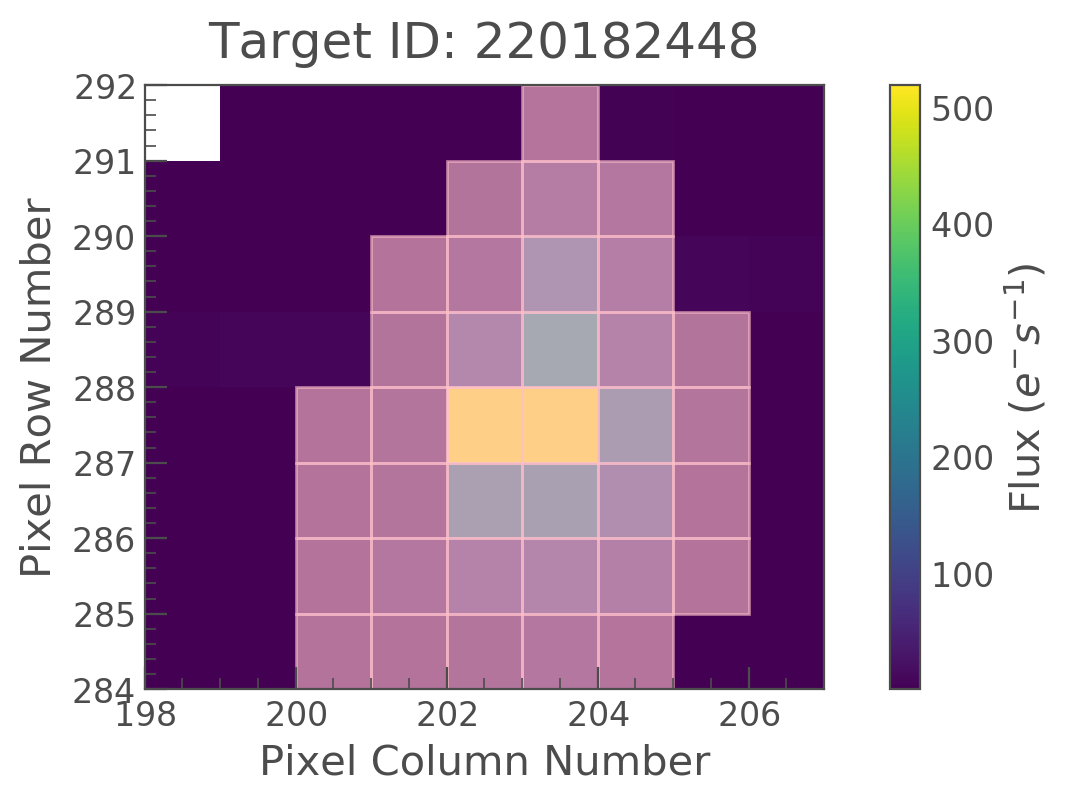

In [8]:
genuine_tpf.plot(aperture_mask=aperture_mask)

In [9]:
lc = genuine_tpf.to_lightcurve(aperture_mask=aperture_mask)

In [10]:
n_cad, = lc.time.shape
n_cad

3595

(3000, 3500)

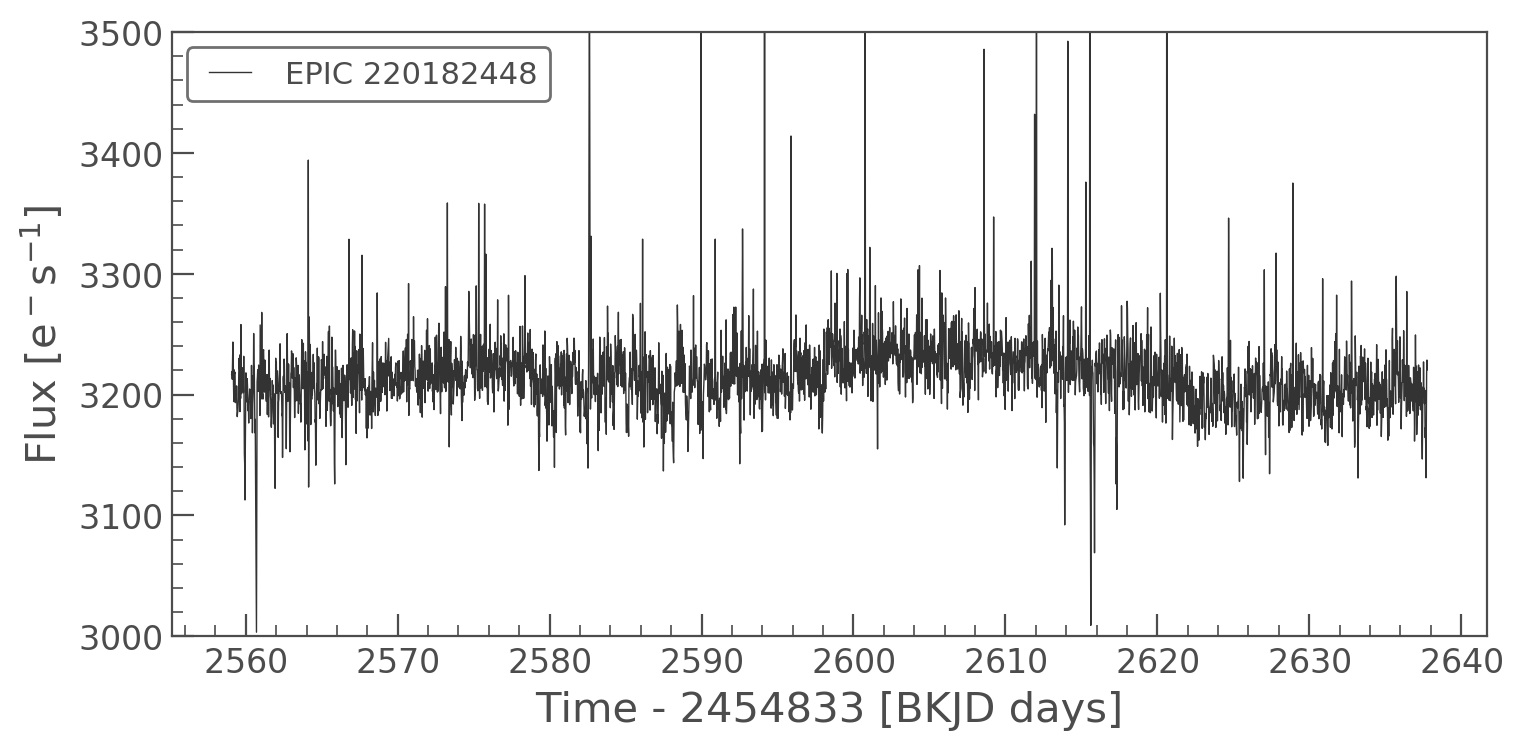

In [11]:
lc.plot(normalize=False)
plt.ylim(3000, 3500)

## Make the data-driven power spectrum.

In [12]:
import astropy.units as u

In [13]:
freq_array = np.linspace(1.0e-8, 1.0e-3, num=1000)*u.Hz

In [14]:
pg = lc.to_periodogram()#frequency=freq_array)

WARNING [astropy._showwarning()]: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead


/Users/obsidian/GitHub/lightkurve/lightkurve/periodogram.py:697: LightkurveWarning: As of Lightkurve v1.0.0 (Apr 2019), the default behavior of Lomb Scargle periodograms changed to use normalization='amplitude' and oversample_factor=5 (the previous defaults were normalization='psd' and oversample_factor=1). You can suppress this warning using `warnings.filterwarnings('ignore', category=lk.LightkurveWarning)`.
  LightkurveWarning)


In [15]:
from astropy.timeseries import LombScargle

f = np.fft.rfftfreq(80*48, 30.0*60)

# Compute the LS based power spectrum estimates
model = LombScargle(lc.time*86400,lc.flux)
power_ls = model.power(f[1:-1], method="fast", normalization="psd")

# >>> To get the LS based PSD in the correct units, normalize by N <<<
power_ls /= len(lc.time)

freq =  f[1:-1]

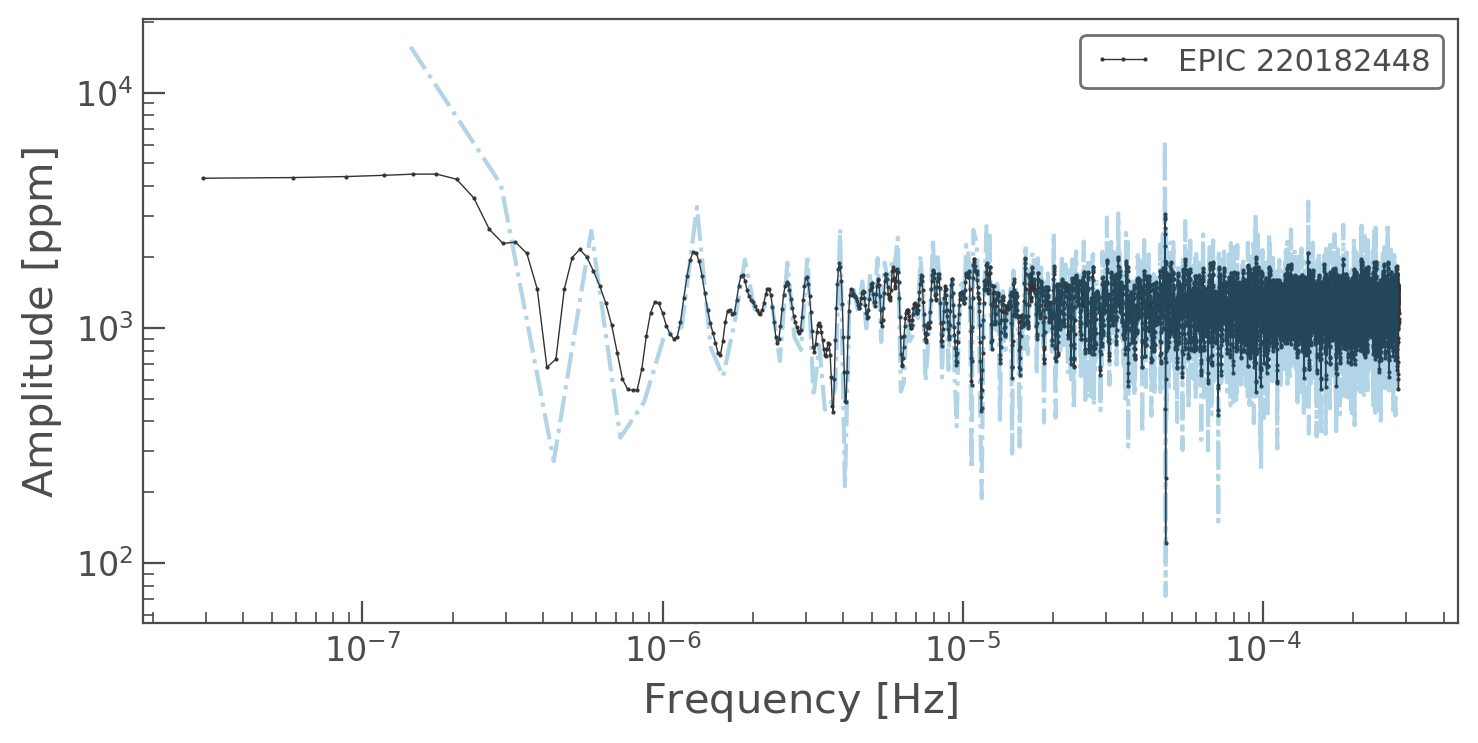

In [16]:
pg.plot(unit=u.Hz, marker='.')
plt.yscale('log')
plt.xscale('log')
plt.plot(freq,power_ls*3e2, '-.', alpha=0.3)

# Modeling a damped random walk.

The power spectrum for a damped random walk resembles this form:

$$S(\omega) = \sqrt{\frac{2}{\pi}}\,\frac{a}{c}\,
    \frac{1}{1+{\left(\frac{\omega}{c}\right)}^2} \quad$$
    
which has the *celerité* **kernel**: 
$$k(\tau_{nm}) = a\,\exp\left(-c\,\tau_{nm}\right)$$.

Note that in the limit of large angular frequencies, the PSD is approximated as a power law with $\alpha=-2$:

$$\lim_{\omega \gg c} S(\omega) \rightarrow \sqrt{\frac{2}{\pi}}\,\frac{a}{c}\,
    \left(\frac{\omega}{c}\right)^{-2} \quad$$
    
We can set $c$ through a desire to have a powerlaw slope through the entire observation window:

$$c>>2 \pi \frac{1}{T_{K2}}$$

Let's set the characteristic time scale as 10 years, well outside the typical 80 day campaign.


In [17]:
t_char = (0.1*u.year).to(u.second)

In [18]:
c_val = 2.0*np.pi * 1/(t_char)

In [19]:
c_val.to(u.Hz) # units of Hertz

<Quantity 1.99102128e-06 Hz>

What about the value of $a$?  It should have units of $(\mathrm{dimensionless\; power}\cdot \mathrm{Hz})$, so it should be comparable to $c$ to achieve near-unity power.

In [23]:
a_val = c_val*1e7

In [24]:
a_val.to(u.Hz)

<Quantity 19.91021278 Hz>

We can use `celerite` to simulate the PSD.

In [25]:
from astropy.stats import LombScargle

import celerite
from celerite import terms

Note that celerité follows the numpy convention of **natural logs** $\ln{}$ for all $\log{}$ functions, unless explicitly providing base 10.

>Args:  
    - log_a (float): The log of the amplitude of the term.  
    - log_c (float): The log of the exponent of the term.

In [26]:
true_logc, true_loga = np.log(c_val.value) , np.log(a_val.value)

In [27]:
kernel = terms.RealTerm(log_a=true_loga, log_c=true_logc) 

In [28]:
gp = celerite.GP(kernel, mean=3200, fit_mean=True)

In [29]:
# Simulate K datasets with N points
t = (lc.time*u.day).to(u.second).value

In [30]:
gp.compute(t)

In [31]:
np.random.seed(42)
NN = n_cad
KK = 500
y = gp.sample(size=KK)

In [32]:
y.shape

(500, 3595)

In [33]:
# Compute the FFT based power spectrum estimates
f = np.fft.rfftfreq(len(t), t[1] - t[0])
fft = np.array(list(map(np.fft.rfft, y)))
fft *= np.conj(fft)

In [34]:
# >>> To get the FFT based PSD in the correct units, normalize by N^2 <<<
power_fft = fft.real / NN**2

In [35]:
# Compute the LS based power spectrum estimates
power_ls = []
for y0 in y:
    model = LombScargle(t, y0)
    power_ls.append(model.power(f[1:-1], method="fast", normalization="psd"))
power_ls = np.array(power_ls)

# >>> To get the LS based PSD in the correct units, normalize by N <<<
power_ls /= NN

WARNING [astropy._showwarning()]: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead


In [36]:
# Compute the true power spectrum
# NOTE: the 2*pi enters because celerite computes the PSD in _angular_ frequency
power_true = kernel.get_psd(2*np.pi*f)

# >>> To get the true PSD in units of physical frequency, normalize by 2*pi <<<
power_true /= 2*np.pi

In [37]:
#  EQN 13 of DFM et al. celerite paper
analytic_power = np.sqrt(2/np.pi)*np.exp(true_loga)/np.exp(true_logc)*1/(1+(2.0*np.pi*f/np.exp(true_logc))**2) / (2*np.pi)

In [38]:
fake_omega = np.logspace(-6, -4, base=10)

In [39]:
fake_pow = fake_omega**(-2) / 1e9

/Users/obsidian/anaconda3/envs/scope_dev/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  # Remove the CWD from sys.path while we load stuff.


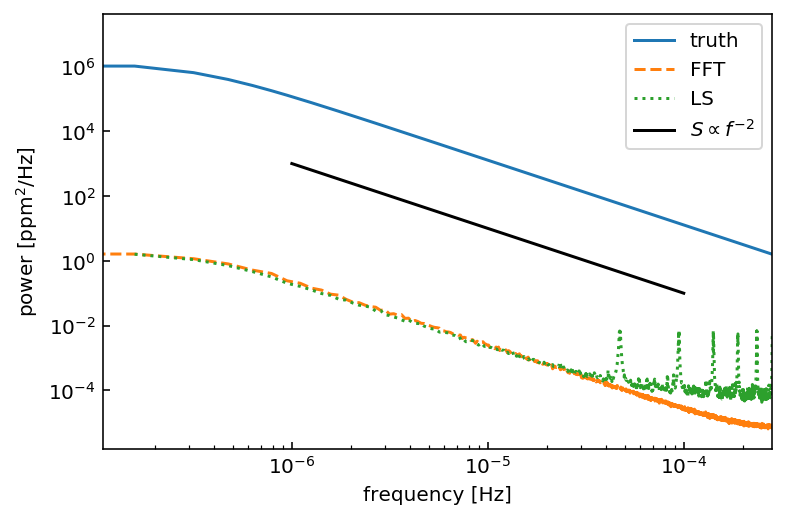

In [40]:
# Let's plot the estimates of the PSD
plt.figure()
#plt.plot(f, power_true, label="truth")
plt.plot(f, power_true, label="truth")
#plt.plot(f, analytic_power, label='analytic')
plt.plot(f, np.median(power_fft, axis=0), "--", label="FFT")
plt.plot(f[1:-1], np.median(power_ls, axis=0), ":", label="LS")
plt.yscale("log")
plt.xscale("log")
plt.xlim(f.min(), f.max())
plt.ylabel("power [$\mathrm{ppm}^2/\mathrm{Hz}$]")
plt.xlabel("frequency [Hz]")

plt.plot(fake_omega, fake_pow, 'k-', label='$S \propto f^{-2}$')

plt.legend()

The normalization scale diverges for [unknown reasons](https://github.com/dfm/celerite/issues/140) but the shape is always preserved.

In [41]:
simulated_signal = y[9, :]

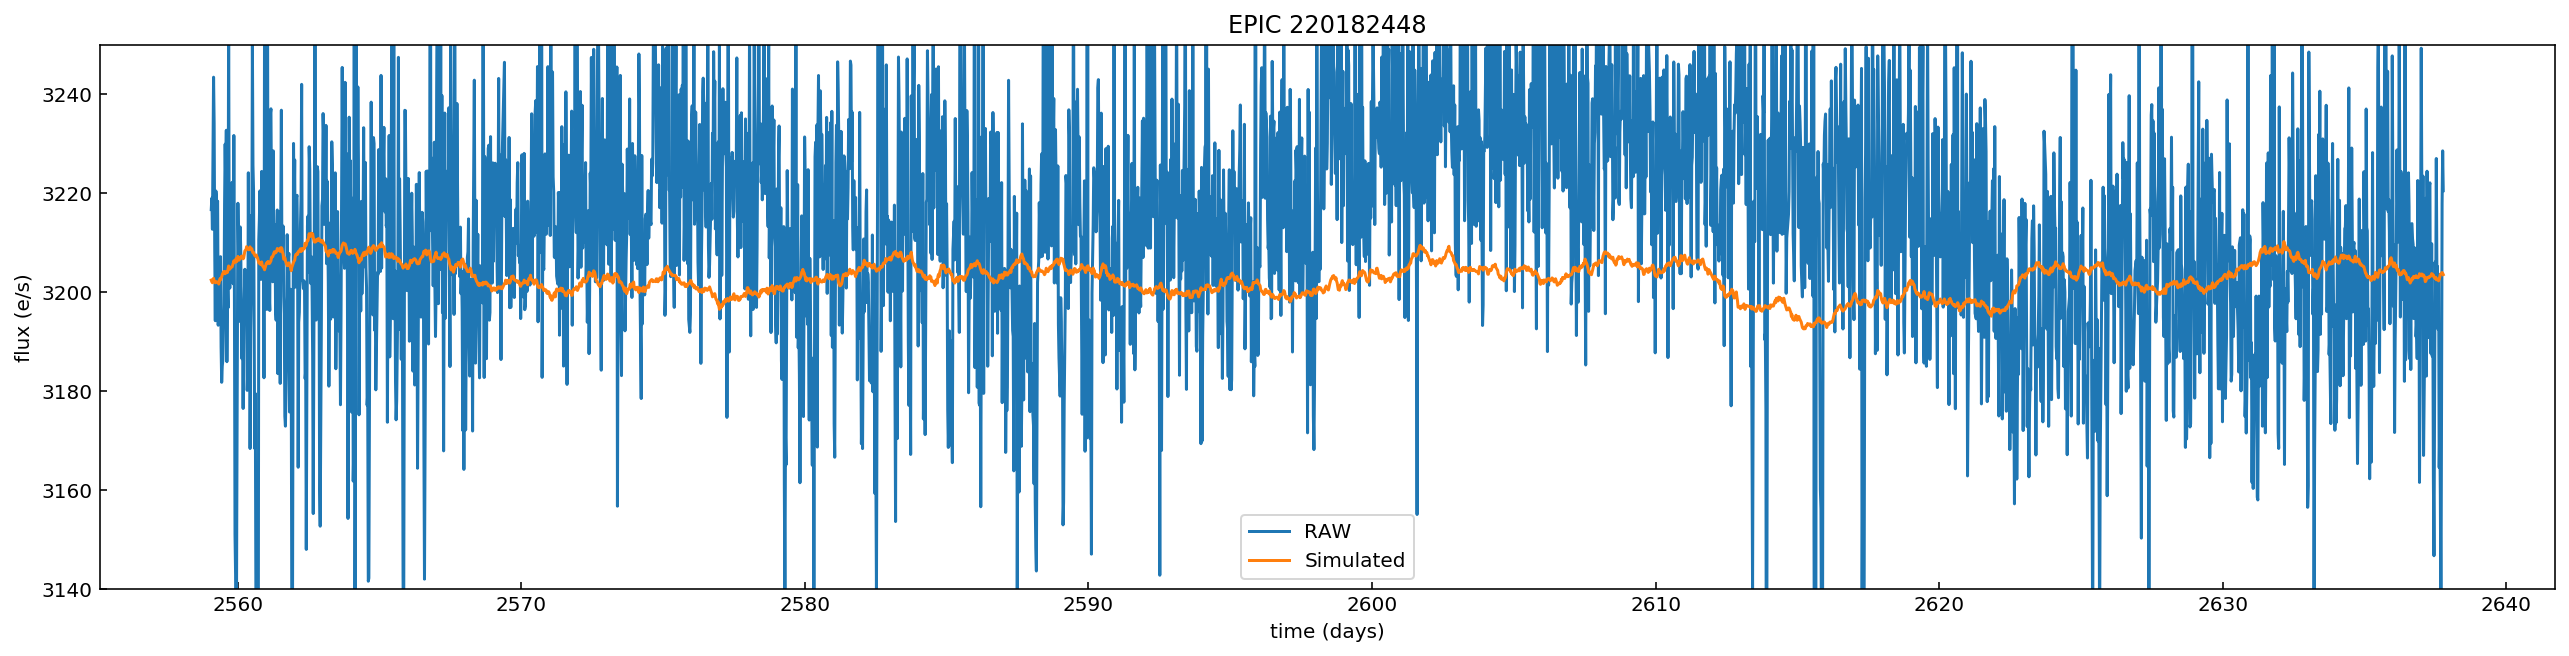

In [42]:
plt.figure(figsize=(22, 5))
plt.plot(lc.time, lc.flux, label='RAW')
plt.plot(t/60/60/24 , simulated_signal, label='Simulated')
plt.ylim(3140, 3250)
plt.title('EPIC {}'.format(lc.targetid))
plt.xlabel('time (days)')
plt.ylabel('flux (e/s)')
plt.legend()

# Make a scope-produced lightkurve

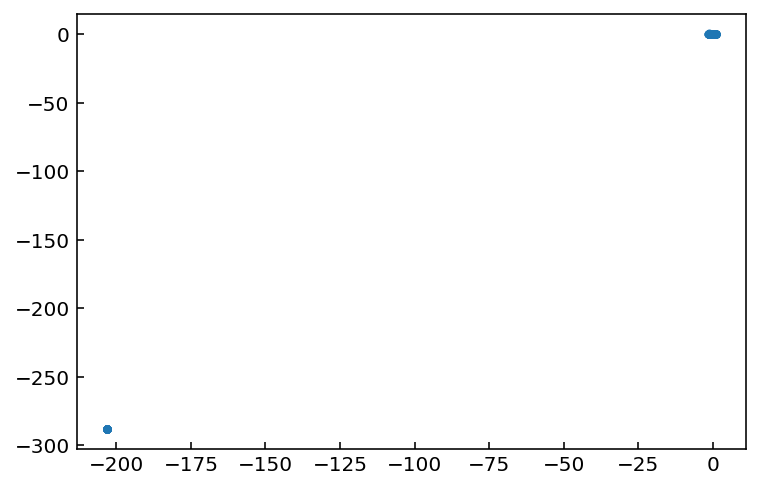

In [43]:
plt.plot(genuine_tpf.pos_corr1, genuine_tpf.pos_corr2, '.')

In [44]:
scope_logger = logging.getLogger('scope') 
scope_logger.setLevel(logging.WARNING) 

In [45]:
targ_mag = genuine_tpf.hdu[0].header['KEPMAG']

In [46]:
target = scope.generate_target(mag=targ_mag, ID=lc.targetid, ncadences=n_cad)

DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTPS connection (2): mast.stsci.edu:443
DEBUG [urllib3.connectionpool._make_request()]: https://mast.stsci.edu:443 "POST /portal/Mashup/Mashup.asmx/columnsconfig HTTP/1.1" 200 None
DEBUG [urllib3.connectionpool._make_request()]: https://mast.stsci.edu:443 "POST /api/v0/invoke HTTP/1.1" 200 None
DEBUG [urllib3.connectionpool._make_request()]: https://mast.stsci.edu:443 "POST /api/v0/invoke HTTP/1.1" 200 None
DEBUG [urllib3.connectionpool._make_request()]: https://mast.stsci.edu:443 "HEAD /api/v0.1/Download/file?uri=mast:K2/url/missions/k2/target_pixel_files/c8/220100000/82000/ktwo220182448-c08_lpd-targ.fits.gz HTTP/1.1" 200 0
INFO  [astropy._download_file()]: Found cached file /Users/obsidian/.lightkurve-cache/mastDownload/K2/ktwo220182448-c08_lc/ktwo220182448-c08_lpd-targ.fits.gz with expected size 4225910.


7% (258/3853) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).


INFO  [lightkurve.utils.create_quality_mask()]: 7% (258/3853) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).


100%|██████████| 3595/3595 [09:37<00:00,  6.27it/s]


In [47]:
time = target.t
target_AGN = copy.copy(target)

The custom variability expects a *multiplicative* signal.  So its mean should be... 1?

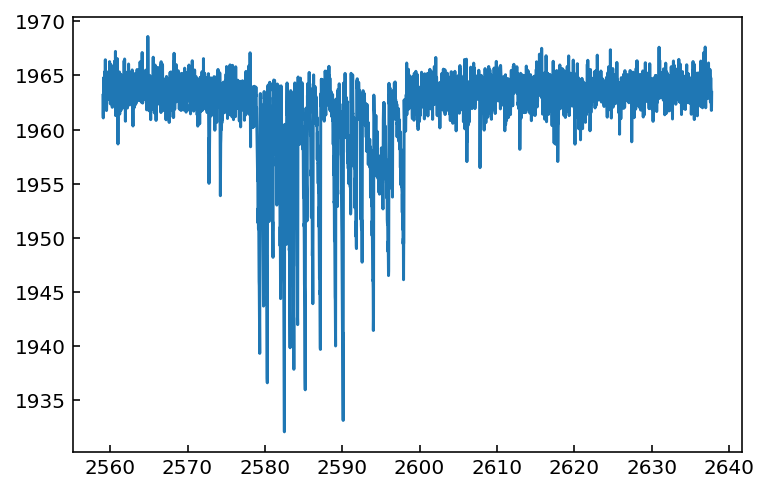

In [48]:
plt.plot(target.time, target.flux)

In [49]:
target_AGN.add_variability(custom_variability=simulated_signal/np.mean(simulated_signal))

100%|██████████| 3595/3595 [09:35<00:00,  6.23it/s]


(2560, 2570)

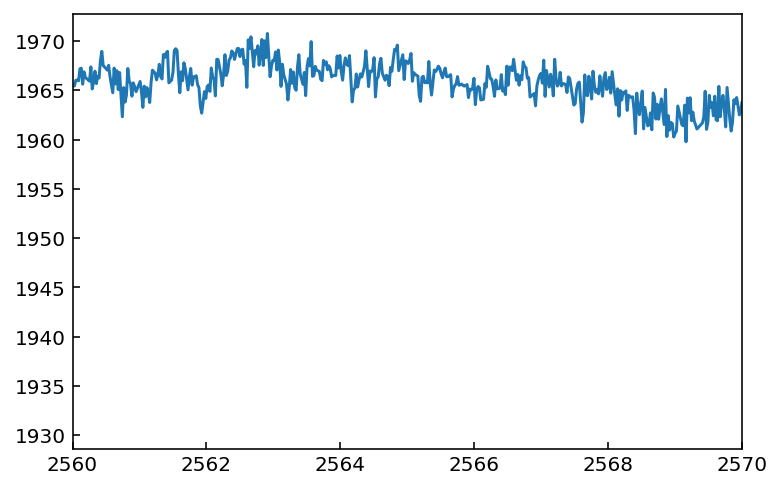

In [50]:
plt.plot(target_AGN.time, target_AGN.flux)
#plt.plot(lc.time, simulated_signal/np.mean(simulated_signal)*target_AGN.flux.mean())
plt.xlim(2560, 2570)

In [51]:
col = genuine_tpf.get_keyword('1CRV5P', hdu=1, default=0)
row = genuine_tpf.get_keyword('2CRV5P', hdu=1, default=0)

In [52]:
AGN_tpf = target_AGN.to_lightkurve_tpf(target_id="simulated_AGN_celerite_RW")
AGN_tpf.hdu[1].header.set('1CRV5P', value=col)
AGN_tpf.hdu[1].header.set('2CRV5P', value=row)

extra_hdu = fits.BinTableHDU.from_columns([fits.Column(name='NOISELESS_INPUT', format='E', 
                                 array=simulated_signal/np.mean(simulated_signal))])
extra_hdu.name = 'SIMULATED_SIGNAL'
AGN_tpf.hdu.append(extra_hdu)
AGN_tpf.hdu[3].header.set('log_a', value=true_loga, comment='ln of celerite a value')
AGN_tpf.hdu[3].header.set('log_c', value=true_logc, comment='ln of celerite c value ')
AGN_tpf.hdu[3].header.set('celmean', value=3200, comment='Mean of pre-normed celerite GP')

AGN_tpf.to_fits(output_fn='synthetic-k2-AGN.targ.fits', overwrite=True)

0% (0/3595) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).


INFO  [lightkurve.utils.create_quality_mask()]: 0% (0/3595) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
WARNING [astropy._showwarning()]: VerifyWarning: Card is too long, comment will be truncated.


### Let's apply the SFF *and* PLD algorithms to compare

In [ ]:
import matplotlib.pyplot as plt

#### SFF (Vanderburg et al. 2015)

In [ ]:
corrector = lk.SFFCorrector(custom_lc)
cor_lc = corrector.correct(genuine_tpf.pos_corr2, genuine_tpf.pos_corr1, 
                             niters=4, windows=1, bins=7, restore_trend=True)

#### PLD (Luger et al. 2016)

In [ ]:
corrector = lk.PLDCorrector(genuine_tpf)
cor_lc2 = corrector.correct(use_gp=True, aperture_mask=aperture_mask, pld_aperture_mask=aperture_mask)

In [ ]:
ax = custom_lc.plot(label='RAW')
cor_lc.plot(label='SFF', ax=ax)
cor_lc2.plot(label='PLD', ax=ax)

plt.ylim(0.85, 1.15)